In [44]:
# Define input and output data
#!pip install torch torchvision torchaudio
#!pip uninstall matplotlib -y
#import matplotlib
#!pip install openpyxl

In [45]:
import torch
torch.manual_seed(0)  # For reproducibility
#!conda --version
#!pip install flaml[automl]
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor as RF
import pickle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import xarray as xr

### Data reading and preprocessing

In [ ]:
# ============ Data loading, preprocessing, and DataLoader ============
# The data catalogue is stored as a CSV file. Here we read it with pandas.
data_path1 = 'D:/A_sem2/ERP/Simulation/new_lhs/lhs_exps.csv'  # Change this to the path of the data file on your system
data_path2 = 'D:/A_sem2/ERP/Code/TSA_max_min_mean.xlsx'
data_path3 = 'D:/A_sem2/ERP/Code/RH2M_max_min_mean.xlsx'  # Change this to the path of the data file on your system
data_path4 = 'D:/A_sem2/ERP/Code/HIA_max_min_mean.xlsx'

# Load the data
df1 = pd.read_csv(data_path1, index_col=0, parse_dates=True)
df1 = df1.drop(columns=['ALB_ROOF_DIF', 'ALB_IMPROAD_DIF', 'ALB_PERROAD_DIF', 'ALB_WALL_DIF', 'WIND_HGT_CANYON'])
df2 = pd.read_excel(data_path2, parse_dates=True)
df3 = pd.read_excel(data_path3, parse_dates=True)
df4 = pd.read_excel(data_path4, parse_dates=True)

# 1. Load inputs and outputs
df_input = df1.values  # Input features from CSV
print(df_input)

# Select the 1st and 3rd columns of df2, df3, df4 (iloc indices 0 and 2)
cols_to_select = [0, 2]
df2_sel = df2.iloc[:, cols_to_select].values
df3_sel = df3.iloc[:, cols_to_select].values
df4_sel = df4.iloc[:, cols_to_select].values

# Horizontally stack into a single matrix of shape [n_samples, 6]
df_output = np.hstack([df2_sel, df3_sel, df4_sel])

# 2. Feature standardization
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(df_input)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(df_output)

# 3. Convert to torch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# 4. Train/test split (you can also use sklearn.model_selection.train_test_split)
train_size = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# 5. DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_848\878898783.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1 = pd.read_csv(data_path1, index_col=0, parse_dates=True)


[[0.86710861 0.99024087 0.15192069 ... 1.12463659 0.0426984  0.35539991]
 [0.68914931 0.83757032 0.18399664 ... 1.68590457 0.78802559 0.36443368]
 [0.44048685 0.90462526 0.21648668 ... 3.77562065 0.21496772 0.58936796]
 ...
 [0.56137753 0.79117553 0.1292929  ... 4.01889391 0.66716056 0.86793034]
 [0.98967886 0.91300226 0.30813693 ... 3.00839137 0.24867129 0.18302804]
 [0.7117039  0.85283726 0.10947204 ... 0.85671413 0.36432908 0.11648628]]


In [47]:
print(y_tensor)

tensor([[ 0.0753,  0.0394, -0.2142, -0.1771, -0.0614,  0.1423],
        [ 0.1438, -0.0909,  0.1791, -0.4720, -0.1321, -0.3126],
        [-0.4933,  0.0370, -0.3766,  0.2136, -0.4590,  0.1458],
        ...,
        [ 0.0763,  0.0556,  0.1597, -0.0551, -0.0513,  0.1700],
        [-0.1077,  0.2839, -1.1374, -0.7180, -0.3275,  0.1811],
        [ 0.3374,  0.5635, -1.4875, -0.9653,  0.0450,  0.4896]])


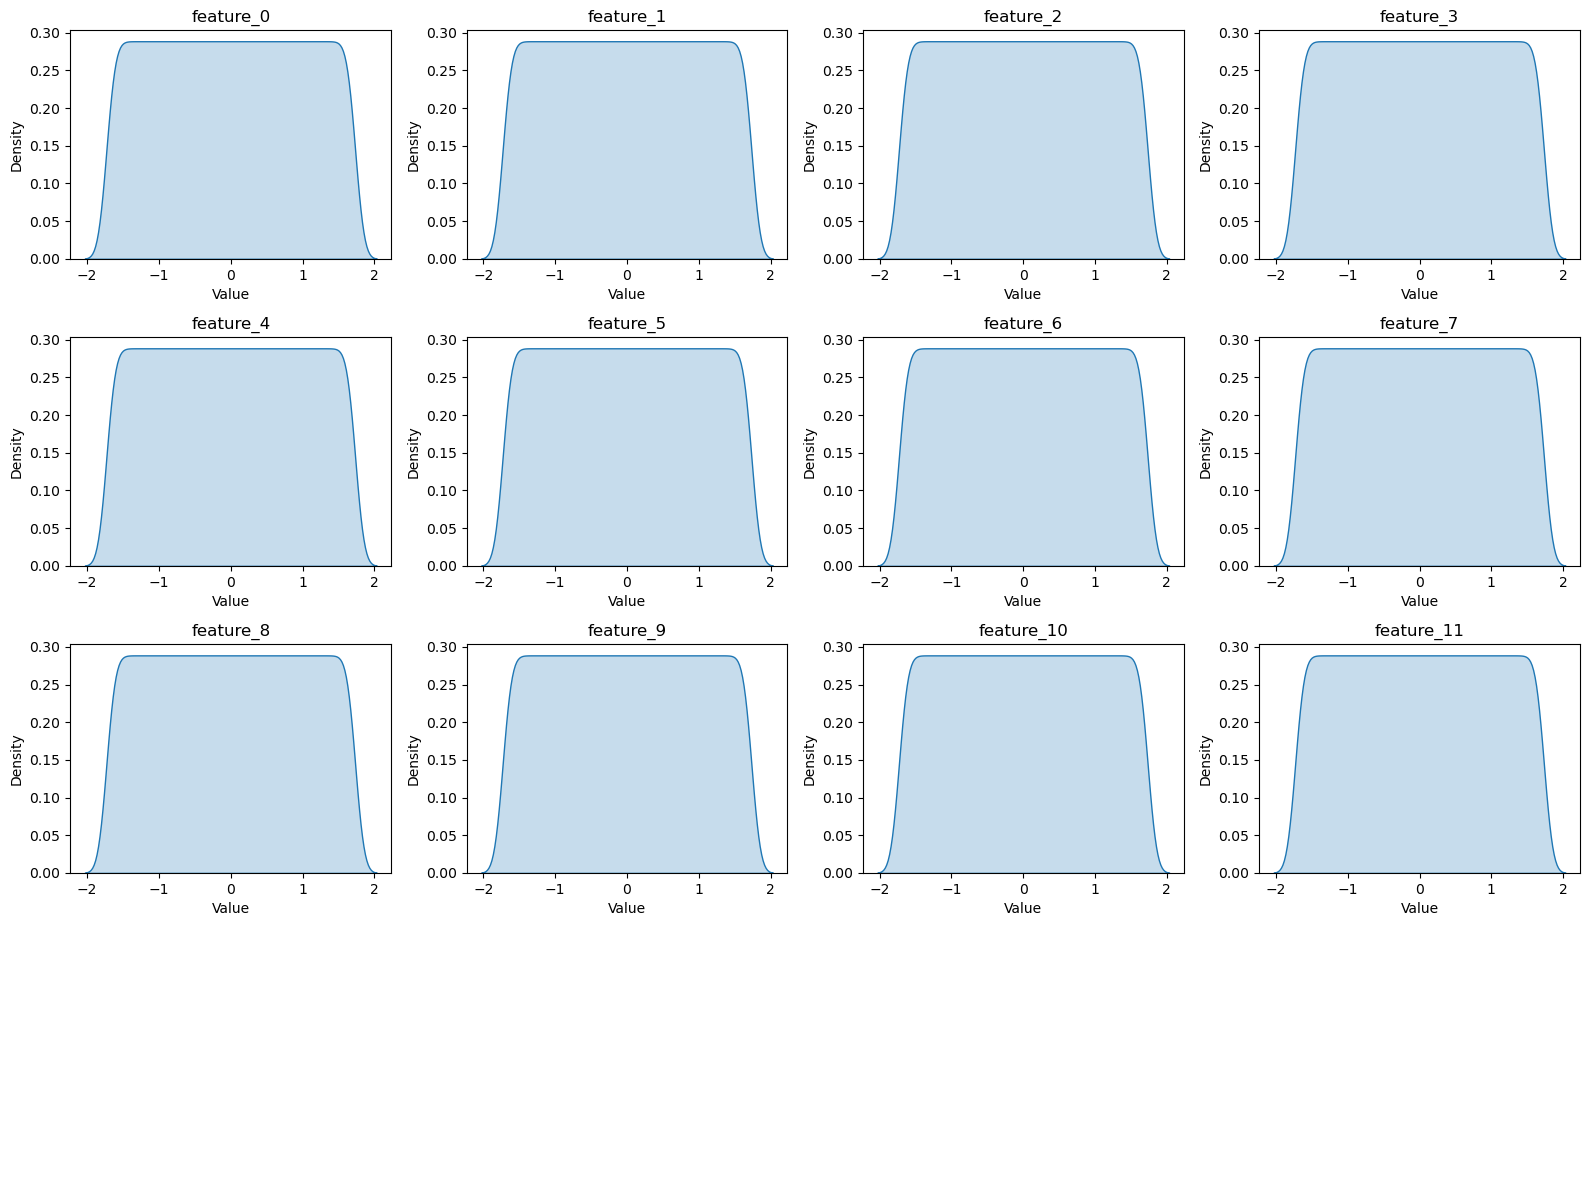

In [ ]:
# ============ Plot KDEs for all features (4x4 grid) ============
# 1. Convert to numpy array, shape [n_samples, n_features]
X_np = X_tensor.numpy()

num_features = X_np.shape[1]
features_names = [f'feature_{i}' for i in range(num_features)]

# Create subplots 4x4 to hold all features
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i in range(num_features):
    sns.kdeplot(X_np[:, i], ax=axes[i], fill=True)
    axes[i].set_title(features_names[i])
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')

# Hide extra subplots
for j in range(num_features, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### 定义MLP模型
nn.Sequential按顺序组合以下层：

nn.Linear(input_dim, 64)：全连接层，将输入维度映射到64个神经元。

nn.ReLU()：激活函数，增加非线性能力。

nn.Linear(64, 32)：第二层全连接，64维映射到32维。

nn.ReLU()：再一次引入ReLU非线性。

nn.Linear(32, 1)：输出层，32维映射到1维，即输出一个标量结果，适合回归。

对nn.Linear(input_dim, 64)的解释：
输入特征（input_dim）数量和**隐层神经元数量（比如64）**没有硬性线性对应关系。
通常隐层神经元要多于输入特征（尤其在特征数量不多时）这样隐层有处理和表达复杂特征的能力。
实际项目中，64、128、32等值都是常见的经验数值起点。

In [ ]:
import torch.nn as nn

class MLPRegressor(nn.Module):
    """
    Define an MLP model. Inherits from nn.Module.
    """
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 6)   # Output size = 6 for multi-output regression
        )

    def forward(self, x):
        return self.model(x)

# Instantiate model
input_dim = X_tensor.shape[1]
model = MLPRegressor(input_dim)

### 训练模型

In [ ]:
# ============ Train model ============
import torch.optim as optim
import torch.nn as nn

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00027400436211074016)  # , weight_decay=1e-4

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(next(model.parameters()).device), yb.to(next(model.parameters()).device)
        optimizer.zero_grad()
        output = model(xb)  # shape [batch_size, 6]
        loss = torch.sqrt(criterion(output, yb))  # RMSE for the batch
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {train_loss:.4f}")

    # Per-output RMSE on the last batch of the epoch
    for i in range(output.shape[1]):
        mse_i = nn.MSELoss()(output[:, i], yb[:, i])
        rmse_i = torch.sqrt(mse_i)
        print(f"Variable {i} RMSE: {rmse_i.item():.4f}")

Epoch 1/100  Train Loss: 0.5882
Variable 0 RMSE: 0.2591
Variable 1 RMSE: 0.2880
Variable 2 RMSE: 0.3730
Variable 3 RMSE: 0.2625
Variable 4 RMSE: 0.3950
Variable 5 RMSE: 0.4416
Epoch 2/100  Train Loss: 0.3013
Variable 0 RMSE: 0.1818
Variable 1 RMSE: 0.2061
Variable 2 RMSE: 0.3407
Variable 3 RMSE: 0.1691
Variable 4 RMSE: 0.2608
Variable 5 RMSE: 0.2843
Epoch 3/100  Train Loss: 0.2669
Variable 0 RMSE: 0.1585
Variable 1 RMSE: 0.1877
Variable 2 RMSE: 0.3333
Variable 3 RMSE: 0.1619
Variable 4 RMSE: 0.2346
Variable 5 RMSE: 0.2451
Epoch 4/100  Train Loss: 0.2537
Variable 0 RMSE: 0.1449
Variable 1 RMSE: 0.1776
Variable 2 RMSE: 0.3321
Variable 3 RMSE: 0.1515
Variable 4 RMSE: 0.2151
Variable 5 RMSE: 0.2261
Epoch 5/100  Train Loss: 0.2445
Variable 0 RMSE: 0.1295
Variable 1 RMSE: 0.1629
Variable 2 RMSE: 0.3250
Variable 3 RMSE: 0.1441
Variable 4 RMSE: 0.1953
Variable 5 RMSE: 0.2087
Epoch 6/100  Train Loss: 0.2371
Variable 0 RMSE: 0.1175
Variable 1 RMSE: 0.1524
Variable 2 RMSE: 0.3137
Variable 3 RMSE:

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Validate model (per-variable evaluation)
model.eval()
with torch.no_grad():
    total_loss = 0
    for xb, yb in test_loader:
        xb, yb = xb.to(next(model.parameters()).device), yb.to(next(model.parameters()).device)
        output = model(xb)
        loss = criterion(output, yb)
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(test_loader.dataset)

    # Predictions and inverse transform (train)
    y_train_pred_scaled = model(X_train.to(next(model.parameters()).device)).cpu().numpy()
    y_train_pred_real = scaler_y.inverse_transform(y_train_pred_scaled)
    y_train_real = scaler_y.inverse_transform(y_train.cpu().numpy())
    residuals_train = y_train_real - y_train_pred_real

    # Predictions and inverse transform (test)
    y_test_pred_scaled = model(X_test.to(next(model.parameters()).device)).cpu().numpy()
    y_test_pred_real = scaler_y.inverse_transform(y_test_pred_scaled)
    y_test_real = scaler_y.inverse_transform(y_test.cpu().numpy())
    residuals_test = y_test_real - y_test_pred_real

    # Training set metrics per variable
    print("Training set metrics per variable:")
    for i in range(y_train_real.shape[1]):  # 6 outputs
        rmse = mean_squared_error(y_true=y_train_real[:, i], y_pred=y_train_pred_real[:, i], squared=False)
        r2 = r2_score(y_true=y_train_real[:, i], y_pred=y_train_pred_real[:, i])
        mae = mean_absolute_error(y_true=y_train_real[:, i], y_pred=y_train_pred_real[:, i])
        print(f"Variable {i+1}: RMSE={rmse:.4f}, R2={r2:.4f}, MAE={mae:.4f}")

    print("\nTesting set metrics per variable:")
    # Testing set metrics per variable
    for i in range(y_test_real.shape[1]):
        rmse = mean_squared_error(y_true=y_test_real[:, i], y_pred=y_test_pred_real[:, i], squared=False)
        r2 = r2_score(y_true=y_test_real[:, i], y_pred=y_test_pred_real[:, i])
        mae = mean_absolute_error(y_true=y_test_real[:, i], y_pred=y_test_pred_real[:, i])
        print(f"Variable {i+1}: RMSE={rmse:.4f}, R2={r2:.4f}, MAE={mae:.4f}")

Training set metrics per variable:
Variable 1: RMSE=0.3189, R2=0.9684, MAE=0.0901
Variable 2: RMSE=0.1168, R2=0.9822, MAE=0.0361
Variable 3: RMSE=1.0441, R2=0.9413, MAE=0.7045
Variable 4: RMSE=0.4936, R2=0.9869, MAE=0.2018
Variable 5: RMSE=0.8530, R2=0.7633, MAE=0.1187
Variable 6: RMSE=0.2529, R2=0.8913, MAE=0.0466

Testing set metrics per variable:
Variable 1: RMSE=0.2717, R2=0.9767, MAE=0.0912
Variable 2: RMSE=0.0952, R2=0.9881, MAE=0.0358
Variable 3: RMSE=1.0512, R2=0.9401, MAE=0.7206
Variable 4: RMSE=0.5052, R2=0.9863, MAE=0.2069
Variable 5: RMSE=0.7106, R2=0.8221, MAE=0.1149
Variable 6: RMSE=0.2215, R2=0.9152, MAE=0.0460


d:\python_Anaconda_install\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\python_Anaconda_install\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\python_Anaconda_install\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\python_Anaconda_install\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, 

<Axes: ylabel='Count'>

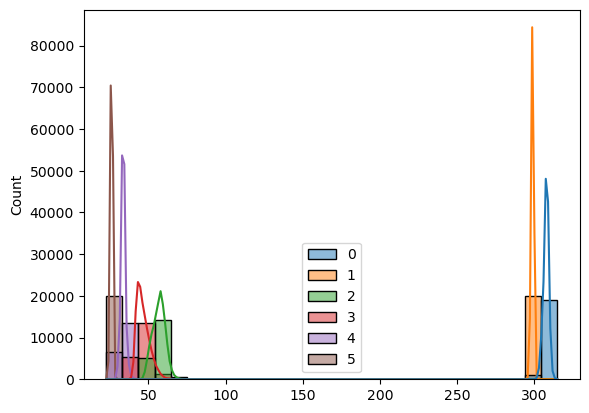

In [52]:
sns.histplot(y_test_pred_real, kde=True, color='blue', label='y_test_pred_real')# , binwidth = 0.1
# sns.histplot(y_test_real, kde=True, color='blue', label='y_test_pred_real')# , binwidth = 0.1

In [ ]:
# save
torch.save(model.state_dict(), "ERP_mlp_regressor_allparameters.pth")
# load
# model.load_state_dict(torch.load("ERP_mlp_regressor_TSAmax.pth"))

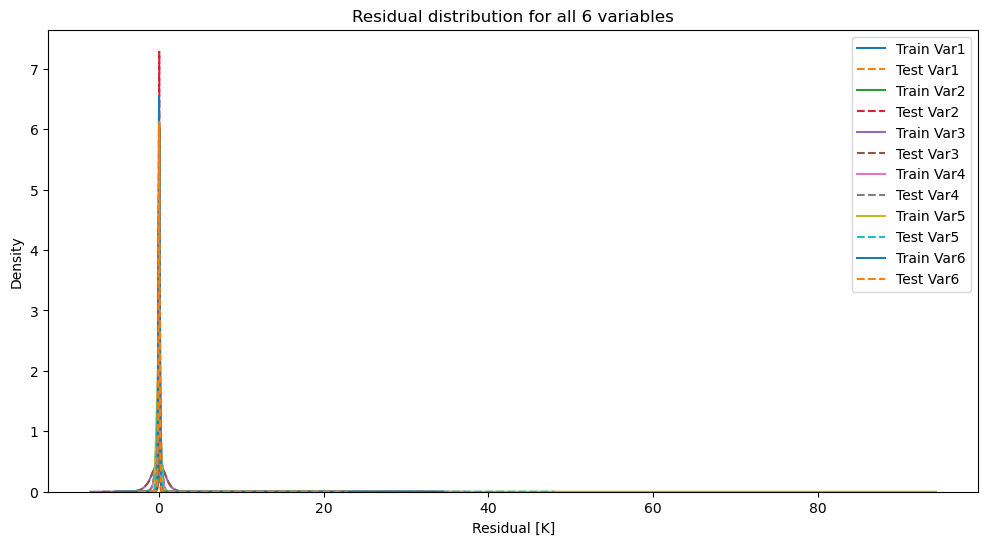

Training set residuals > 20 count per variable:
Variable 1: 5
Variable 2: 0
Variable 3: 36
Variable 4: 28
Variable 5: 33
Variable 6: 2

Testing set residuals > 20 count per variable:
Variable 1: 0
Variable 2: 0
Variable 3: 6
Variable 4: 8
Variable 5: 5
Variable 6: 1
Training set residuals > 20 count and percentage per variable:
Variable 1: Count=5, Ratio=0.01%
Variable 2: Count=0, Ratio=0.00%
Variable 3: Count=36, Ratio=0.04%
Variable 4: Count=28, Ratio=0.03%
Variable 5: Count=33, Ratio=0.04%
Variable 6: Count=2, Ratio=0.00%


In [41]:
plt.figure(figsize=(12, 6))

for i in range(6):
    sns.kdeplot(residuals_train[:, i], label=f'Train Var{i+1}', linewidth=1.5)
    sns.kdeplot(residuals_test[:, i], label=f'Test Var{i+1}', linestyle='--', linewidth=1.5)

plt.xlabel('Residual [K]')
plt.ylabel('Density')
plt.title('Residual distribution for all 6 variables')
plt.legend()
plt.show()

threshold = 20

print("Training set residuals > 20 count per variable:")
for i in range(6):
    count = (residuals_train[:, i] > threshold).sum()
    print(f"Variable {i+1}: {count}")

print("\nTesting set residuals > 20 count per variable:")
for i in range(6):
    count = (residuals_test[:, i] > threshold).sum()
    print(f"Variable {i+1}: {count}")

print("Training set residuals > 20 count and percentage per variable:")
for i in range(6):
    count = (residuals_train[:, i] > threshold).sum()
    ratio = count / residuals_train.shape[0] * 100
    print(f"Variable {i+1}: Count={count}, Ratio={ratio:.2f}%")

100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


shap_values.shape: (100, 12, 6)
X_explain.shape: (100, 12)
len(feature_names): 12
feature_names: ['ALB_ROOF_DIR', 'EM_ROOF', 'ALB_IMPROAD_DIR', 'EM_IMPROAD', 'ALB_PERROAD_DIR', 'EM_PERROAD', 'ALB_WALL_DIR', 'EM_WALL', 'HT_ROOF', 'CANYON_HWR', 'WTLUNIT_ROOF', 'WTROAD_PERV']


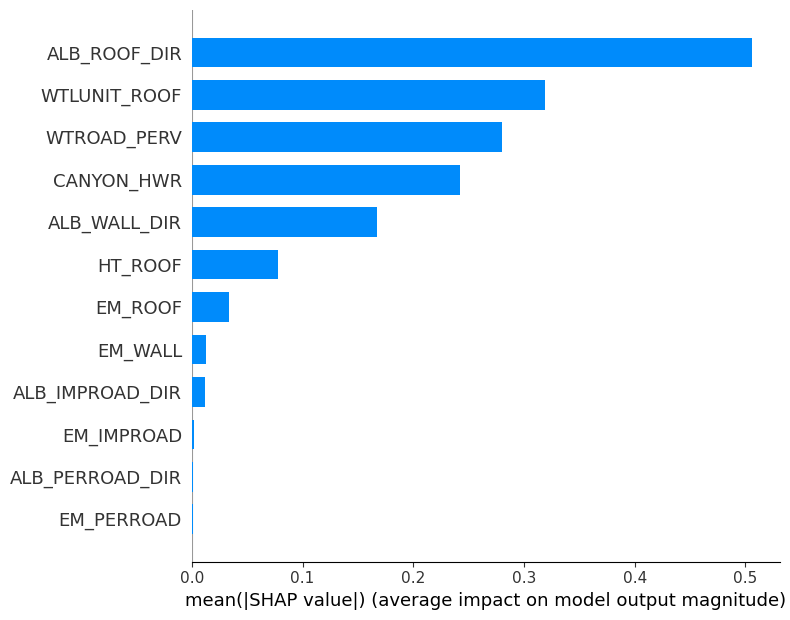

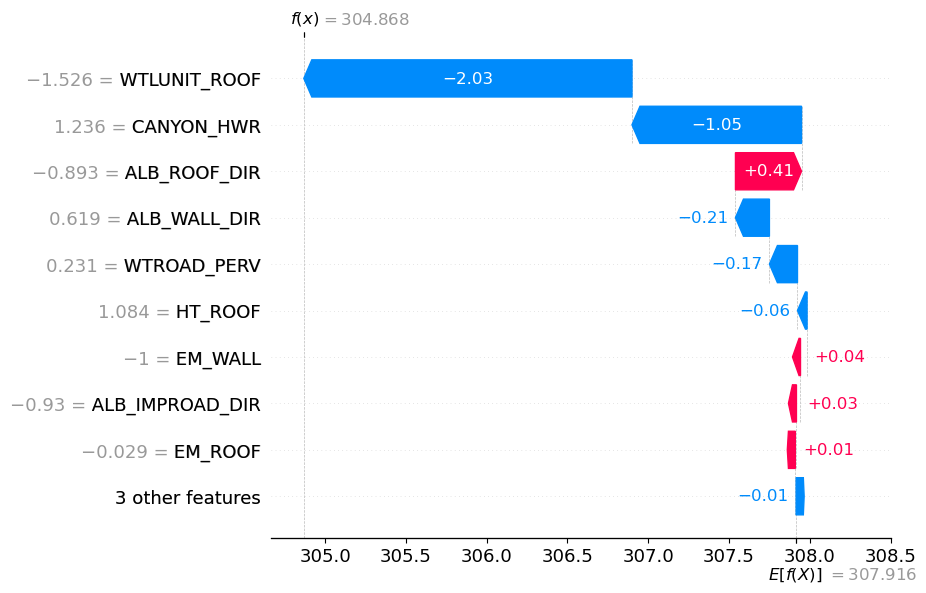

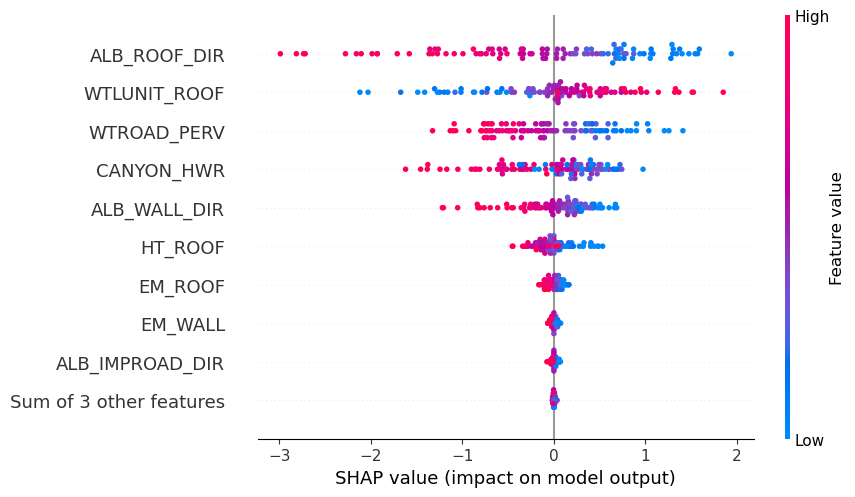

[[-1.2992636  -0.15047252 -0.01274207 ... -0.84526118  1.3286526
  -0.45801084]
 [ 0.68011795 -0.01709055  0.02720437 ...  0.40635011 -0.72603671
  -0.42035343]
 [ 1.0628417   0.08047752 -0.00291072 ...  0.24102289  0.50736424
  -0.19871505]
 ...
 [-0.73986413 -0.05861066 -0.05588385 ...  0.68513298 -0.06899268
   0.45349977]
 [ 1.05311128 -0.05841415 -0.0224311  ...  0.08471994  0.26021107
   0.42198059]
 [ 0.51247185  0.00311148  0.00727372 ...  0.3607548   0.0742521
  -0.72111083]]


In [ ]:
import shap
import numpy as np
import torch

# Ensure model is in evaluation mode
model.eval()

# Convert tensors to numpy arrays if needed
X_train_np = X_train.cpu().numpy() if hasattr(X_train, "cpu") else X_train
X_test_np = X_test.cpu().numpy() if hasattr(X_test, "cpu") else X_test

# Prediction wrapper for SHAP (accepts numpy array, returns numpy array)
def model_predict(x):
    import torch
    x_tensor = torch.tensor(x, dtype=torch.float32)
    with torch.no_grad():
        return model(x_tensor).cpu().numpy()

# Background dataset (use up to 100 samples from training set for KernelExplainer)
background = X_train_np[np.random.choice(len(X_train_np), min(100, len(X_train_np)), replace=False)]
# Instances to explain (first 100 test samples or fewer if not available)
X_explain = X_test_np[:100]

# Create KernelExplainer (note: very slow for large feature counts and many explain instances)
explainer = shap.KernelExplainer(model_predict, background)
shap_values_mlp = explainer.shap_values(X_explain)

# Feature names from df1 (input dataframe)
feature_names = df1.columns.tolist()

print("shap_values.shape:", np.shape(shap_values_mlp))
print("X_explain.shape:", X_explain.shape)
print("len(feature_names):", len(feature_names))
print("feature_names:", feature_names)

In [43]:
# 加载shap_values
with open('ERP_MLP_shap_values.pkl', 'rb') as f:
    shap_values_MLP = pickle.load(f)

print(shap_values_MLP.shape)

(5600, 13, 1)
